In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64
N_EPOCHS   = 100
DATA_PATH = '../datasets/MNIST/'
Z_DIM = 2

In [3]:
#cuda!
#test on colab at least one iteration
class VAE(nn.Module):
    def __init__(self, D, d = Z_DIM):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, D)
        self.decoder = Decoder(d, D)
        
        #d - for latent space
        self.d = d
        self.D = D
        
    def count_vlb(self, X, i):
        #get parameters of z distribution
        mu_z, var_z = self.encoder(X)

        #sample latent(mu_z, var_z)
        z = Normal(torch.zeros(mu_z.size()), torch.ones(mu_z.size())).sample()
        z = mu_z + torch.sqrt(var_z) * nn.Parameter(z, requires_grad=False).to(device)
        latent_loss = 0.5 * (var_z + mu_z**2 - torch.log(var_z+1e-12) - 1).mean(dim=0).sum()
        
        #get parameters of x_hat distribution
        mu_x, var_x = self.decoder(z)
        normal = Normal(mu_x, torch.sqrt(var_x))
        reconstruction_loss = normal.log_prob(X).mean(dim=0).sum()
        #count loss
        #coefs are to be chosen
        return -(reconstruction_loss - latent_loss), latent_loss, reconstruction_loss
                   
    def generate_samples(self, num_samples):
        z = torch.FloatTensor(np.random.normal(0, 1, size=[num_samples, self.d, 1, 1])).to(device)
        return self.decoder(z)

In [4]:
class Encoder(nn.Module):
    def __init__(self, d, D):
        super(Encoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        
        self.fc_mu = nn.Conv2d(64, Z_DIM, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [5]:
class Decoder(nn.Module):
    def __init__(self, d, D):
        super(Decoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        self.fc_mu = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [6]:
device='cuda'
vae = VAE(49).to(device)
vae.load_state_dict(torch.load("vae_weights.pth"))

In [7]:
#transform data to tensor and normalize (values state for MNIST!)
trans = tt.Compose([tt.ToTensor()]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True,  transform=trans, download=False) 
test_dataset  = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(BATCH_SIZE, -1)

In [ ]:
class FConvMNIST(nn.Module):
    def __init__(self):
        super(FConvMNIST, self).__init__()
        
        self.conv1   = nn.Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
        self.relu    = nn.LeakyReLU(negative_slope=0.01)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2   = nn.Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
        self.flat    = Flatten()
        self.clf     = nn.Linear(in_features=1152, out_features=10, bias=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        return self.clf(self.flat(x)) 

In [ ]:
device='cuda'
model = FConvMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
vae.generate_samples(32)[0].size()

torch.Size([32, 1, 7, 7])

In [ ]:
print("1", model.conv1.weight[0])
model.conv1.weight = nn.Parameter(vae.generate_samples(32)[0])
print("2", model.conv1.weight[0])

1 tensor([[[-0.1055, -0.0073,  0.0881, -0.0607, -0.0919, -0.0491, -0.0191],
         [-0.0686,  0.0187,  0.1359, -0.0357, -0.0116, -0.0727, -0.0830],
         [ 0.0486,  0.0721,  0.0993, -0.0520,  0.0552, -0.0868,  0.0595],
         [ 0.1294, -0.0316, -0.0567,  0.0783, -0.0668,  0.1337, -0.0163],
         [ 0.1241, -0.0969,  0.1406,  0.1175, -0.0510, -0.1090, -0.1242],
         [-0.1406, -0.0586,  0.0172,  0.0268,  0.0182,  0.0703, -0.0112],
         [-0.1101, -0.0693,  0.0796,  0.1162,  0.1059, -0.0840, -0.1076]]],
       device='cuda:0', grad_fn=<SelectBackward>)
2 tensor([[[ 0.0042,  0.0108,  0.0076,  0.0041, -0.0075, -0.0461, -0.0568],
         [-0.0169,  0.0066,  0.0117,  0.0017, -0.0167, -0.0308, -0.0327],
         [-0.0444, -0.0162, -0.0105, -0.0222, -0.0379, -0.0249,  0.0471],
         [-0.0309, -0.0096, -0.0200, -0.0469, -0.0566, -0.0160,  0.1109],
         [-0.0170, -0.0174, -0.0390, -0.0583, -0.0600,  0.0155,  0.1724],
         [-0.0335, -0.0341, -0.0416, -0.0534, -0.0354,  

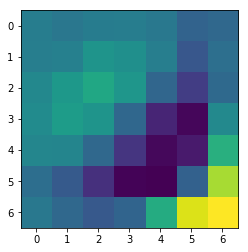

In [ ]:
mu_x = model.conv1.weight.detach().cpu().numpy()
plt.imshow(mu_x[4].reshape((7, 7)))

In [ ]:
vae_acc = []
vanilla_acc = []

In [ ]:
loss_list = []
acc_list  = []
test_acc_list = []

N_STEPS = len(train_loader)
print(N_STEPS)

viewed_batches = 0
#train network
for j in range(N_EPOCHS):
    for k, (images, labels) in enumerate(train_loader):
        if (images.shape[0] < BATCH_SIZE):
                break
        #forward
        labels = labels.to(device)
        pred = model(images.to(device))
        loss = criterion(pred, labels)
        loss_list.append(loss.item())

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        viewed_batches += 1
        
        if viewed_batches % 1 == 0:
            print("samples ", viewed_batches * BATCH_SIZE)

        #statictics
        total = labels.size(0)
        _, predicted = torch.max(pred.data, 1)

        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        test_acc = []
        for i, (test_images, test_labels) in enumerate(test_loader):
            if (test_images.shape[0] < BATCH_SIZE):
                break
            test_labels = test_labels.to(device)
            pred = model(test_images.to(device))

            #statictics
            total = test_labels.size(0)
            _, predicted = torch.max(pred.data, 1)

            correct = (predicted == test_labels).sum().item()
            test_acc.append(correct / total)

        test_acc_list.append(np.mean(test_acc))
        
        if viewed_batches == 100:
            break
    if viewed_batches == 100:
        break
    

938
samples  64
samples  128
samples  192
samples  256
samples  320
samples  384
samples  448
samples  512
samples  576
samples  640
samples  704
samples  768
samples  832
samples  896
samples  960
samples  1024
samples  1088
samples  1152
samples  1216
samples  1280
samples  1344
samples  1408
samples  1472
samples  1536
samples  1600
samples  1664
samples  1728
samples  1792
samples  1856
samples  1920
samples  1984
samples  2048
samples  2112
samples  2176
samples  2240
samples  2304
samples  2368
samples  2432
samples  2496
samples  2560
samples  2624
samples  2688
samples  2752
samples  2816
samples  2880
samples  2944
samples  3008
samples  3072
samples  3136
samples  3200
samples  3264
samples  3328
samples  3392
samples  3456
samples  3520
samples  3584
samples  3648
samples  3712
samples  3776
samples  3840
samples  3904
samples  3968
samples  4032
samples  4096
samples  4160
samples  4224
samples  4288
samples  4352
samples  4416
samples  4480
samples  4544
samples  4608
samp

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
# plt.plot([i for i in range(len(acc_list))], acc_list, label = 'train_accuracy')
plt.plot([i for i in range(len(test_acc_list))], test_acc_list, label = 'test_accuracy')

vae_acc.append(test_acc_list)

plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [ ]:
model = FConvMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
vanilla_loss_list = []
vanilla_acc_list  = []
vanilla_test_acc_list = []

N_STEPS = len(train_loader)
print(N_STEPS)
viewed_batches = 0
#train network
for j in range(N_EPOCHS):
    for k, (images, labels) in enumerate(train_loader):
        if (images.shape[0] < BATCH_SIZE):
                break
        #forward
        labels = labels.to(device)
        pred = model(images.to(device))
        loss = criterion(pred, labels)
        vanilla_loss_list.append(loss.item())

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        viewed_batches += 1
        
        if viewed_batches % 1 == 0:
            print("samples ", viewed_batches * BATCH_SIZE)

        #statictics
        total = labels.size(0)
        _, predicted = torch.max(pred.data, 1)

        correct = (predicted == labels).sum().item()
        vanilla_acc_list.append(correct / total)

        vanilla_test = []
        for i, (test_images, test_labels) in enumerate(test_loader):
            if (i > 20 or test_images.shape[0] < BATCH_SIZE):
                break
            test_labels = test_labels.to(device)
            pred = model(test_images.to(device))
            optimizer.step()

            #statictics
            total = test_labels.size(0)
            _, predicted = torch.max(pred.data, 1)

            correct = (predicted == test_labels).sum().item()
            vanilla_test.append(correct / total)

        vanilla_test_acc_list.append(np.mean(vanilla_test))
        
        if viewed_batches == 100:
            break
    if viewed_batches == 100:
        break

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(test_acc_list, label = 'vae_test_acc')
plt.plot(vanilla_test_acc_list, label = 'xav_test_acc')

vanilla_acc.append(vanilla_test_acc_list)

plt.xlabel('n samples')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(vae_acc)